<a href="https://colab.research.google.com/github/csharpshooter/EVA/blob/master/A12/A12-A/A12-A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import datetime
print("Model execution started at:" + datetime.datetime.today().ctime())

Model execution started at:Fri May 22 21:26:18 2020


In [2]:
from src.dataset.monocularhelper import MonocularHelper
from src.imports import *
import torch.optim.lr_scheduler
import os
# from src.train.torchvision import collate_fn, train_one_epoch, warmup_lr_scheduler, MetricLogger, SmoothedValue

%config IPCompleter.greedy=True
%reload_ext autoreload

In [3]:
%autoreload 2  # Autoreload all modules

In [4]:
# def printgpuinfo():
#     gpu_info = !nvidia-smi
#     gpu_info = '\n'.join(gpu_info)
#     if gpu_info.find('failed') >= 0:
#       print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#       print('and then re-execute this cell.')
#     else:
#       print(gpu_info)
    
# printgpuinfo()

In [5]:
# def showsysteminfo():
#     from psutil import virtual_memory
#     ram_gb = virtual_memory().total / 1e9
#     ram_gb_avail = virtual_memory().available / 1e9
#     ram_gb_used = virtual_memory().active / 1e9
#     print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
#     print('Your runtime has {:.1f} gigabytes of free RAM\n'.format(ram_gb_avail))
#     print('Your runtime has {:.1f} gigabytes of used RAM\n'.format(ram_gb_used))    
# showsysteminfo()

In [6]:
import torch
print(torch.__version__)

1.2.0


In [7]:
helper = MonocularHelper()
# final_output = r'/media/abhijit/DATA/Development/TSAI/EVA/MaskRCNN Dataset/OverLayedImages'
# final_output_mask = r'/media/abhijit/DATA/Development/TSAI/EVA/MaskRCNN Dataset/OverLayedMask'
# final_output_dm = r'/media/abhijit/DATA/Development/TSAI/EVA/MaskRCNN Dataset/OverLayedDepthMasks'
# bg_path = r'/media/abhijit/DATA/Development/TSAI/EVA/MaskRCNN Dataset/Background'

final_output = r'C:\MonocularDS\OverLayedImages'
final_output_mask = r'C:\MonocularDS\OverLayedMask'
final_output_dm = r'C:\MonocularDS\OverLayedDepthMasks'
bg_path = r'C:\MonocularDS\Background'

train_data, train_label, test_data, test_label = helper.get_train_test_data(masks_folder=final_output_mask,
                                                                            images_folder=final_output,
                                                                            depth_masks_folder=final_output_dm,
                                                                            no_of_batches=40,
                                                                            total_images_count=400000,
                                                                            bg_folder=bg_path)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.33it/s]


In [8]:
print(len(train_label))
print(len(test_label))

batch_size = 16
image_size = 128

train_transforms, test_transforms = preprochelper.PreprocHelper.getpytorchtransforms(image_net_mean, image_net_std, image_size)
ds = dst.Dataset()

train_dataset = ds.get_monocular_train_dataset(train_image_data=train_data, train_image_labels=train_label,
                                               train_transforms=train_transforms)

test_dataset = ds.get_monocular_test_dataset(test_image_labels=test_label, test_image_data=test_data,
                                             test_transforms=test_transforms)

torch.manual_seed(1)

dataloader = dl.Dataloader(traindataset=train_dataset, testdataset=test_dataset, batch_size=batch_size)
train_loader = dataloader.gettraindataloader()
test_loader = dataloader.gettestdataloader()

280000
120000
CUDA Available? True
16


cuda


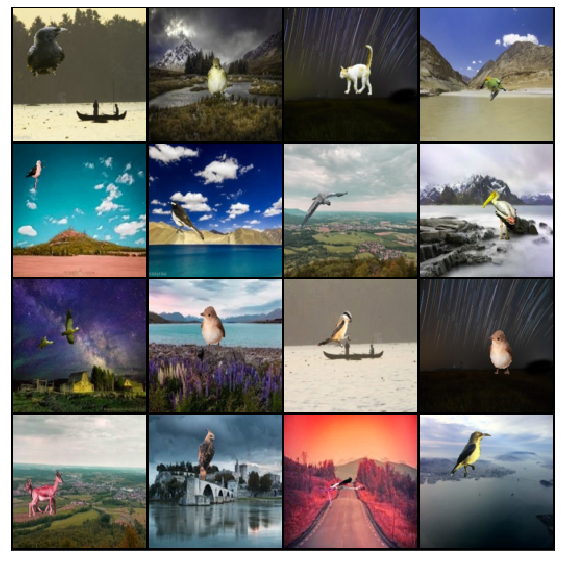

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 64, 64]              27
            Conv2d-2           [-1, 64, 64, 64]             256
DepthwiseSeparableConv2d-3           [-1, 64, 64, 64]               0
              ReLU-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]             576
            Conv2d-6          [-1, 128, 64, 64]           8,320
DepthwiseSeparableConv2d-7          [-1, 128, 64, 64]               0
              ReLU-8          [-1, 128, 64, 64]               0
        BasicBlock-9          [-1, 128, 64, 64]               0
       BasicBlock-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]           1,152
           Conv2d-12           [-1, 64, 64, 64]           8,256
DepthwiseSeparableConv2d-13           [-1, 64, 64, 64]               0
             ReLU-14

In [9]:
import torch.nn as nn
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")

cnn_model, device = utils.Utils.createMonocularModel()
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.01, momentum=0.9, weight_decay=1e-5)

# for name, param in cnn_model.named_parameters():
#     print(name)
#     print(param)

for name, param in cnn_model.named_parameters():    
    if "bn1" in name or "bn2" in name:
        nn.init.constant_(param, 0)        
    elif "weight" in name:
        nn.init.kaiming_normal_(param, mode="fan_out", nonlinearity="relu")
    elif "bias" in name:
        nn.init.constant_(param, 0)

# last_epoch = 1

# if os.path.exists("savedmodels/checkpoint1.pt"):
#     checkpoint, epoch, model_state_dict, optimizer_state_dict, train_losses, train_acc, test_losses, test_acc \
#         , test_losses, lr_data, class_correct, class_total = utils.Utils.loadmodel("savedmodels/checkpoint1.pt")
#     cnn_model.load_state_dict(model_state_dict)
#     # optimizer.load_state_dict(optimizer_state_dict)
#     last_epoch = last_epoch + checkpoint['epoch']

# cnn_model = torchvision.models.resnet18(pretrained=False, num_classes=2).cuda(device)


sample = next(iter(train_loader))

imgs = sample[0][0]

# grid_tensor = torchvision.utils.make_grid(imgs, 2)
# grid_image = grid_tensor.permute(1, 2, 0)

utils.Utils.show(imgs, nrow=4)

train_model = train.TrainModel()
# print(cnn_model)
# print(cnn_model.parameters())
train_model.showmodelsummary(model=cnn_model,input_size=[(4,3,64,64)])
# optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.01, momentum=0.9, weight_decay=1e-5)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=1, 
            verbose=True, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

lr_data = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
epochs = 20

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(cnn_model))

In [ ]:
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss, MSELoss, L1Loss
from src.train.customlossfunction import DiceLoss
# loss_fn = BCEWithLogitsLoss()
# loss_fn = L1Loss()
# loss_fn = MSELoss()
loss_fn = DiceLoss()
show_output = False
infer_index = 2
for epoch in range(1, epochs):
    print("EPOCH:", epoch)
    
    tr_out = train_model.train_Monocular(cnn_model, device, train_loader, optimizer, epoch, loss_fn, show_output, infer_index)
    ts_out, dice_loss = train_model.test_Monocular(cnn_model, device, test_loader, class_correct, class_total, epoch, lr_data, loss_fn, 
                                        show_output, infer_index)
    
    from src.utils.utils import Utils

    Utils.show(tr_out.detach().cpu(), nrow=4)
    Utils.show(ts_out.detach().cpu(), nrow=4)
    
    scheduler.step(dice_loss)

# train_losses, train_acc = train_model.gettraindata()
# test_losses, test_acc = train_model.gettestdata()
# utils.Utils.savemodel(model=cnn_model, epoch=epochs, path="savedmodels/finalmodelwithdata.pt",
#                       optimizer_state_dict=optimizer.state_dict
#                       , train_losses=train_losses, train_acc=train_acc, test_acc=test_acc,
#                       test_losses=test_losses, lr_data=lr_data, class_correct=class_correct, class_total=class_total)

In [ ]:
import os
model_save_path = "savedmodels" + os.path.sep + "finalmodelwithdata.pt"
train_losses, train_acc = train_model.gettraindata()
test_losses, test_acc = train_model.gettestdata()
utils.Utils.savemodel(model=cnn_model, epoch=epochs, path="finalmodelwithdata.pt",
                      optimizer_state_dict=optimizer.state_dict
                      , train_losses=train_losses, train_acc=train_acc, test_acc=test_acc,
                      test_losses=test_losses, lr_data=lr_data, class_correct=class_correct, class_total=class_total)